In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [4]:
df = pd.read_csv('data/monthly_milk_production.csv', index_col='Date', parse_dates=True)
df.index.freq = 'MS' #specifying the data to be monthly data

In [5]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


<AxesSubplot:xlabel='Date'>

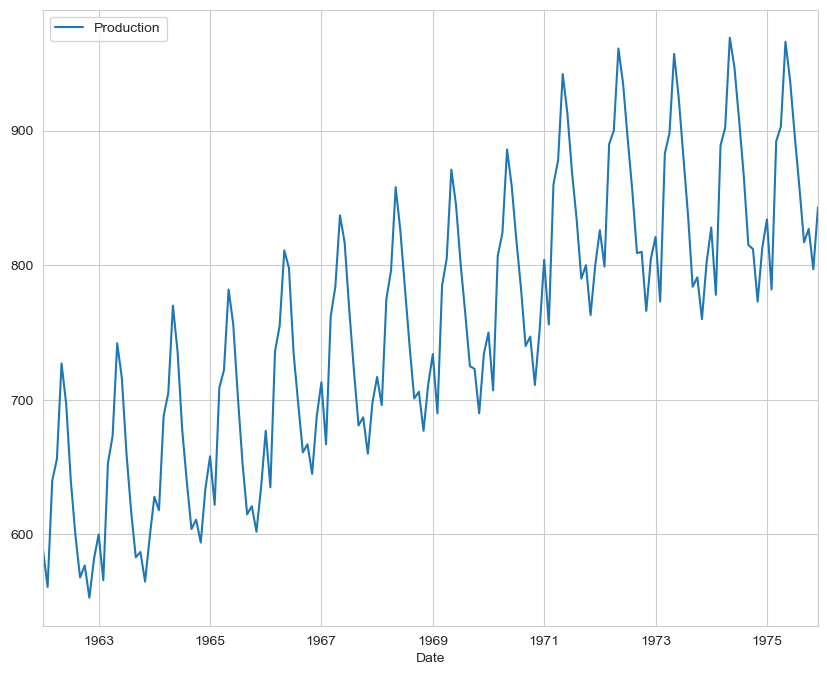

In [8]:
df.plot(figsize=(10, 8))

* Here we can see that there is a seonal trend and also the data is constatnly increasing.
* To verify this we can simply decompose the time series and check it.

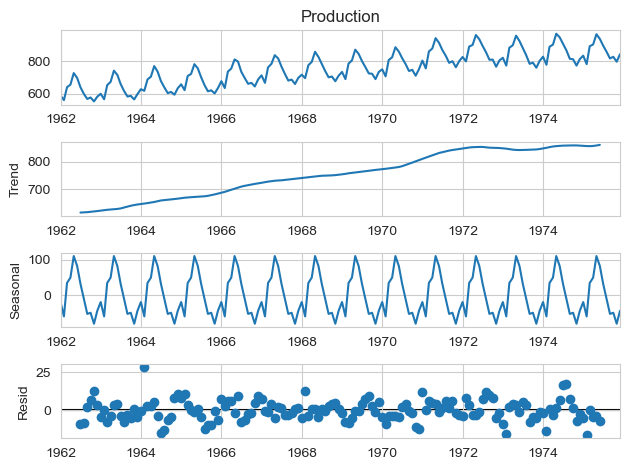

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df['Production'])
decompose.plot()
plt.tight_layout()

* By looking at this we see the increasing trend in the graph.
* Also there is clearly a seasonal component to it.

* Now do we need to convert this data into a stationary one for our LSTM model? Not necessarily.
* Most neural network models do not require the timeseries to be stationary in nature.
* However it is advisable to do so. The model's accuracy of its predictions are often better with stationary data.
* So we can first test with the non-stationary data, and if required we can do the required changes.
* In this case we are just going to proceed with the non-stationary data as it is.

In [13]:
len(df)

168

In [12]:
train = df.iloc[:156]
test = df.iloc[156:]

In [14]:
df.head(), df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

* We can see that there is a bog difference between the start of the values and towards the end.
* To avoid having such large values we can normalize the data using the MinMax technique.

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [16]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [17]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [18]:
scaled_test

array([[0.67548077],
       [0.55048077],
       [0.81490385],
       [0.84134615],
       [0.99278846],
       [0.92307692],
       [0.82451923],
       [0.73317308],
       [0.63461538],
       [0.65865385],
       [0.58653846],
       [0.69711538]])

* Now we have to format the data to pass to the model.

In [19]:
from keras.preprocessing.sequence import TimeseriesGenerator

* The above function will generate batches of the inputs and their labels according to our specifications.

In [23]:
n_input = 3 #we are predicting the 4th value by passing every 3 values as input
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)#inputs, labels, lenth of the output, size of the batches

In [26]:
#first generated batch
X, y = generator[0]
print(f'Given the input: {X.flatten()}')
print(f'Predict the y: {y}')

Given the input: [0.08653846 0.01923077 0.20913462]
Predict the y: [[0.24759615]]


In [27]:
#second generated batch
X, y = generator[1]
print(f'Given the input: {X.flatten()}')
print(f'Predict the y: {y}')

Given the input: [0.01923077 0.20913462 0.24759615]
Predict the y: [[0.41826923]]


In [28]:
X.shape #(rows, cols, #features)

(1, 3, 1)

* Now we will generate by taking 12 months of data as the data is montly inputted.

In [35]:
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [40]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.fit(generator, epochs=30)

Epoch 1/30
144/144 [==============================] - 3s 6ms/step - loss: 0.0464
Epoch 2/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0214
Epoch 3/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0168
Epoch 4/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0123
Epoch 5/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0076
Epoch 6/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0079
Epoch 7/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0058
Epoch 8/30
144/144 [==============================] - 1s 7ms/step - loss: 0.0051
Epoch 9/30
144/144 [==============================] - 1s 9ms/step - loss: 0.0035
Epoch 10/30
144/144 [==============================] - 2s 13ms/step - loss: 0.0037
Epoch 11/30
144/144 [==============================] - 2s 11ms/step - loss: 0.0043
Epoch 12/30
144/144 [==============================] - 2s 12ms/step - loss: 0.0033
Epoch 13/30
144/144 [=

Text(0, 0.5, 'Loss')

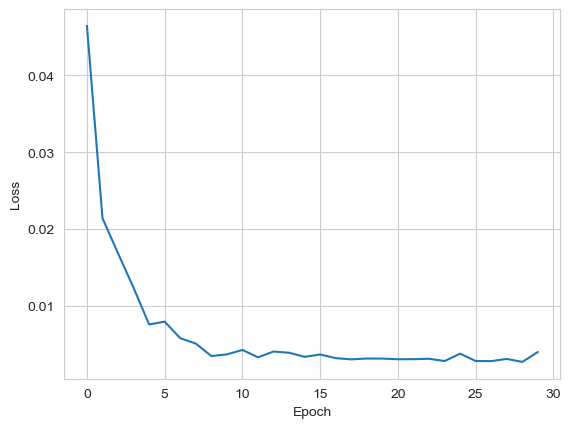

In [43]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')

* Now we can make predictions on the test set.

In [44]:
last_train_batch = scaled_train[-12:] #last 12 months data to predict the next month

In [45]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [46]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 285ms/step


array([[0.6517936]], dtype=float32)

In [47]:
scaled_test[0]

array([0.67548077])

* By comparing with the actual result we can see that the model has given a fairly accurate prediction.

In [48]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    #get the prediction of the current batch
    current_pred = model.predict(current_batch)[0]

    #append the predictions into the array
    test_predictions.append(current_pred)

    #update the batch
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 [==============================] - 0s 44ms/step


In [49]:
test_predictions

[array([0.6517936], dtype=float32),
 array([0.6606561], dtype=float32),
 array([0.8259819], dtype=float32),
 array([0.92855966], dtype=float32),
 array([1.0680125], dtype=float32),
 array([1.0431933], dtype=float32),
 array([0.95350826], dtype=float32),
 array([0.83137083], dtype=float32),
 array([0.7198184], dtype=float32),
 array([0.6685541], dtype=float32),
 array([0.6302007], dtype=float32),
 array([0.6560114], dtype=float32)]

* Here we can see that the outputs are in the range of 0 - 1 due to our MinMax operation.
* So we must return it bach to the original state.

In [50]:
true_predictions = scaler.inverse_transform(test_predictions)

In [51]:
test['Predictions'] = true_predictions

C:\Users\delli\AppData\Local\Temp\ipykernel_17992\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [52]:
test

,Production,Predictions
Date,,
1975-01-01,834,824.146137
1975-02-01,782,827.832935
1975-03-01,892,896.608477
1975-04-01,903,939.280819
1975-05-01,966,997.293190
1975-06-01,937,986.968430
1975-07-01,896,949.659435
1975-08-01,858,898.850266
1975-09-01,817,852.444460


<AxesSubplot:xlabel='Date'>

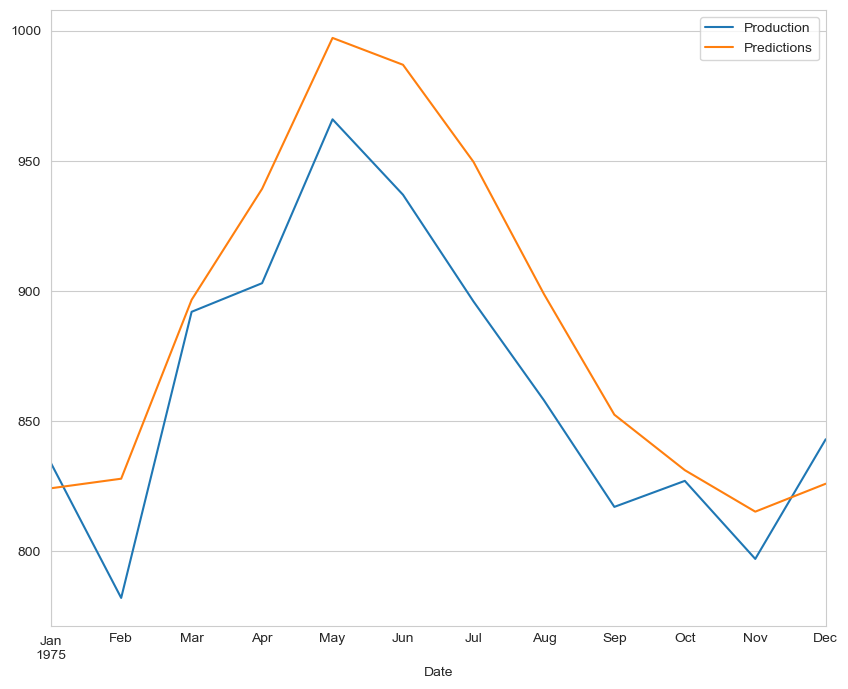

In [53]:
test.plot(figsize=(10, 8))

* As we can see, the predictions were fairly accurate.
* We can now calculate the error metric.

In [54]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test['Production'], test['Predictions']))
rmse

33.485131024997045